Dataset Source: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks/data <br>
Additional Source: https://www.kaggle.com/datasets/henryhan117/sp-500-historical-data

Description: This dataset has 3 csv files
1. sp500_index: This contains daily values of s&p500 index
2. sp500_stocks: This contain OHLC data for individual stocks that make up the s&p500
3. sp500_companies: This contains metadata for individual stocks that make up the s&p500

#Part 1: Initial Preprocessing
1. The index data and the individual stock data are for different timeframes i.e there is about 4 more years of individual stock data over the index data. We will be sourcing this data from a different dataset to get a uniform timeframe for the dataset. This will have to be followed by data normalization as well.
2. The s&p 500 index changes as per the underlying stocks so sp500_index dataset is essentially the output variable for all the individual stock variables in sp500_stocks. These multiple datasets will have to be combined through data integration.
3. sp500_companies has a lot of string data which could be categoricaly used, however we are initally interested in the float data such as market cap and ebidta. These will have to be extracted from the dataset and combined into the main dataset
4. There are a few missing values in our dataset. We could use imputation to  fill these missing values or skip the date with the missing value as well

#Part 2: Features
1. The column names of the feature(s) you plan to use for the final project, and the target outcome you plan to determine using these features.
  - Sector/Industry
    - The fluctuation of stock prices may depend on which sector/industry the product serves, which will be important for modeling -- we would not want to model datapoints together if they do not behave in the same patterns.
  - Revenue Growth
    - The fluctuation of the stock prices could potentially depend on the revenue growth of the product.
  - Open/High/LowVolume/Adjusted Close
    - We plan to use the columns 'Open', 'High', 'Low', 'Volume', and 'Adjusted Close' prices of the stocks and predict the next day's 'Close' price for the stocks using these features.
  - Marketcap
      - Market capitalization indicates the company's size and can influence investor perceptions and stock stability
  - Ebitda
      - Earnings before interest, taxes, depreciation, and amortization (EBITDA) may give us information company's operating performance and in turn stock patterns.
  - S&P500
    - S&P500 can be the target outcome since the movement in individual stocks directly affect the index. Columns in sp_stocks can be the predictor variables, however we would have to consider the weight of each one to find the columns that have a significant impact on the index.

  - (P/E) ratio
    - We plan to use the columns related to price-to-earnings (P/E) ratio and dividend yield as features for predicting the target outcome, which will be the future stock price. The P/E ratio is a common indicator of how much investors are willing to pay for each dollar of earnings, and dividend yield reflects the return on investment through dividends, which can influence stock price movements.

2. Your initial plan for any feature engineering (e.g. adding a Boolean for weekend vs. weekday or taking the ratio of two other features).
  - We can use one-hot encoding or a variant of it to encode the different sectors/industries, though this may prove to cause an issue of extremely high dimensionality, and we may have to find an alternative encoding method.
  - We will have to normalize data across the columns based on the 'date' column to make accurate predictions Also each individual stock could be considered a single predictor variable to reduce dimensionality
  - We plan to enhance our dataset by calculating moving averages to identify trends, creating a new feature for the daily price range by subtracting 'Low' from 'High', and adding a Boolean indicator to highlight whether the day is at the beginning or end of the week to capture weekly patterns.
  - There are some features (such as Ebitda) with missing values. For this, we will either drop the missing values or impute the values with mean, median, or a previous value (as this dataset has 4 years of data). Imputation is a more ideal method for features where dropping samples greatly impacts our analysis.
    - We have 4 years of index data missing. We will be will be fill this data from the additional datasource. If we still endup with any missing data, we could fill the those with previous day values.
  - We plan to create a momentum indicator by calculating the difference between the current stock price and the average price over a set period (e.g., 10 days or 30 days). This will help capture the trend and momentum of a stock’s price movement, which could be predictive of future price changes.
3. If you plan to use any sort of method for dealing with imbalanced data, detail your overall approach (e.g. "will oversample class XYZ", or "will create synthetic data using SMOTE"). If you do not intend to use any techniques to deal with imbalanced data, explain why it is not necessary (e.g. "all features are at worst imbalanced 7:3").
  - ADASYN could be a good synthetic data generation method for minority classes, since it creates more difficult learning examples, and the nature of predicting stock patterns is highly variable; the more flexible the model, the better.
  - To handle imbalanced data, we plan to use ensemble techniques like Balanced Random Forest, which combines the predictive power of multiple decision trees. It adjusts for imbalances by undersampling the majority class within each tree, ensuring that the model does not overfit to common patterns while learning important minority class behaviors, such as rare stock price fluctuations.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns
import matplotlib as plt
import re

in_colab = True
base_path = ''
if in_colab == True:
    drive.mount('/content/drive')
    base_path = '/content/drive/MyDrive/602_Project/'

sp_index = pd.read_csv(base_path+'data/sp500_index.csv')
sp_stocks = pd.read_csv(base_path+'data/sp500_stocks.csv')
sp_comp = pd.read_csv(base_path+'data/sp500_companies.csv')
spx = pd.read_csv(base_path+'data/SPX.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sp_index.head()

,Date,S&P500
0,2014-09-15,1984.13
1,2014-09-16,1998.98
2,2014-09-17,2001.57
3,2014-09-18,2011.36
4,2014-09-19,2010.40


In [ ]:
sp_stocks.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,44.016724,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,43.741020,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,44.361351,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,44.393162,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,44.705975,70.501671,70.501671,69.648827,69.974915,4073337.0


In [ ]:
sp_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Exchange             503 non-null    object 
 1   Symbol               503 non-null    object 
 2   Shortname            503 non-null    object 
 3   Longname             503 non-null    object 
 4   Sector               503 non-null    object 
 5   Industry             503 non-null    object 
 6   Currentprice         503 non-null    float64
 7   Marketcap            503 non-null    int64  
 8   Ebitda               474 non-null    float64
 9   Revenuegrowth        501 non-null    float64
 10  City                 503 non-null    object 
 11  State                483 non-null    object 
 12  Country              503 non-null    object 
 13  Fulltimeemployees    498 non-null    float64
 14  Longbusinesssummary  503 non-null    object 
 15  Weight               503 non-null    flo

## Data Transformation

### Handling individual stocks in sp_stocks
sp_stocks has OHLC data for the individual stocks that make up the s&p500, however this is arranged stockwise instead of datewise. The first order of business would be to modify this to a transform to a chronological order.

P.S This transformation has a long runtime!


In [ ]:
df = pd.DataFrame(sp_stocks['Date'].unique(), columns=['Date'])
symbols = sp_stocks['Symbol'].unique()

#joining columns for each symbol in the form Open_{Symbol}... with Date as key
for symbol in symbols:
    df = pd.merge(df, sp_stocks.loc[sp_stocks['Symbol'] == symbol, ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].add_suffix(f'_{symbol}'), left_on='Date', right_on='Date'+f'_{symbol}', validate='one_to_one').drop(columns=['Date'+f'_{symbol}'])

# Ensure the data is sorted by date
df = df.sort_values(by='Date').reset_index(drop=True)

In [ ]:
sp_stocks = df
#clearing memory
df = df.iloc[0:0]

### Backfilling missing data from SPX
The original dataset had data missing for the s&p500 index from 2010 to 2014. We could pull the data from spx dataset, which contains values dating back to 1927. We can also take the approach of using spx itself for all the index values, since sp500_index is essentially a subset of spx, with the added benefit that spx also has OHLC data as compared to only the closing values, which could be useful for further analysis

In [ ]:
spx = spx.rename(columns={"Close":"SP500"}).drop(columns=['Open','High','Low','Adj Close'])
df = pd.merge(spx, sp_stocks, left_on='Date', right_on='Date', validate='one_to_one')
df = df.sort_values(by='Date').set_index('Date')

### Missing Values
Since the S&P500 is made up of 500 individual companies, over the period there are new additions and removals to the index, this means that the bucket of 500 companies does not stay the same. We have missing data in these cases as the company was not present in the top 500. Since a company not present in the index has no contribution to the index, we can set its value to zero.

In [ ]:
df = df.interpolate(method ='linear', limit_direction ='forward')
df = df.fillna(value=0)
df.isna().sum()

,0
SP500,0
Volume,0
Open_MMM,0
High_MMM,0
Low_MMM,0
...,...
High_ZTS,0
Low_ZTS,0
Close_ZTS,0
Adj Close_ZTS,0


### Creating Train and Test Data

### DONT RERUN THIS CELL

In [ ]:
#df.to_csv(base_path+'data/processed.csv')

### Long Short Term Memory Neural Network


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

# Load data
data = pd.read_csv(base_path + 'data/processed.csv')
data['Date'] = pd.to_datetime(data['Date'])  # Ensure Date column is datetime

# Sort by date
data = data.sort_values('Date').reset_index(drop=True)

# Handle missing values
data = data.fillna(method='ffill').fillna(method='bfill')

# Target and feature selection
target = 'SP500'
features = [col for col in data.columns if col not in ['Date', target]]

#differentiating for stationarity
data[target + '_diff'] = data[target].diff().fillna(0)

# Train-test split
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Shift the target variable AFTER splitting
train_data[target + '_diff'] = train_data[target + '_diff'].shift(-1)
test_data[target + '_diff'] = test_data[target + '_diff'].shift(-1)

# Drop rows with NaN due to shifting
train_data = train_data.dropna().reset_index(drop=True)
test_data = test_data.dropna().reset_index(drop=True)

# Scale features and target on training set only
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

scaled_train_features = scaler_features.fit_transform(train_data[features])
scaled_train_target = scaler_target.fit_transform(train_data[[target + '_diff']])

scaled_test_features = scaler_features.transform(test_data[features])
scaled_test_target = scaler_target.transform(test_data[[target + '_diff']])

# Combine scaled data
train_scaled = np.hstack([scaled_train_features, scaled_train_target])
test_scaled = np.hstack([scaled_test_features, scaled_test_target])


<ipython-input-5-1b09bacbff7a>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


In [6]:
# Define PyTorch Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.sequence_length, :-1]  # Predictor variables
        y = self.data[idx + self.sequence_length, -1]  # Target variable
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Sequence length for LSTM
sequence_length = 30

# Create datasets and loaders
train_dataset = TimeSeriesDataset(train_scaled, sequence_length)
test_dataset = TimeSeriesDataset(test_scaled, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

# Model parameters
input_size = len(features)
hidden_size = 64
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss and optimizer
criterion = nn.L1Loss()  # MAE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training Loop only needs to be ran for retraining

In [ ]:
# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output.squeeze(), y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}')

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=20)

In [7]:
# Evaluate the model
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    predictions, actuals = [], []
    with torch.no_grad():
        for x, y in test_loader:
            output = model(x)
            loss = criterion(output.squeeze(), y)
            total_loss += loss.item()
            predictions.append(output.squeeze().numpy())
            actuals.append(y.numpy())
    print(f'Test Loss: {total_loss / len(test_loader):.4f}')
    return np.concatenate(predictions), np.concatenate(actuals)

# Load the best model (if saved previously)
model.load_state_dict(torch.load(base_path+'model/sp500_lstm_model.pth'))

# Test the model
predictions, actuals = evaluate_model(model, test_loader, criterion)

# Inverse transform predictions and actuals to original scale
predictions = scaler_target.inverse_transform(predictions.reshape(-1, 1))
actuals = scaler_target.inverse_transform(actuals.reshape(-1, 1))


# Extract dates corresponding to the predictions
prediction_dates = test_data['Date'].iloc[sequence_length:].reset_index(drop=True)

# Select the corresponding original SP500 values for reverse differencing
original_sp500 = test_data[target].iloc[sequence_length - 1 : sequence_length - 1 + len(predictions)].values

# Add back the original values to the predictions and actuals for reversing differencing
predictions_original = predictions.flatten() + original_sp500
actuals_original = original_sp500

# Combine results with dates for better clarity
lstm_results_df = pd.DataFrame({
    'Date': prediction_dates,
    'Prediction': predictions_original,
    'Actual': actuals_original
})

# Display a sample of the results
print("Sample Predictions vs Actuals with Dates:")
print(lstm_results_df.head(10))

<ipython-input-7-b6adfcfefd99>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(base_path+'model/sp500_lstm_model.pth'))


Test Loss: 0.6302
Sample Predictions vs Actuals with Dates:
        Date   Prediction       Actual
0 2018-10-18  2806.242725  2809.209961
1 2018-10-19  2765.826658  2768.780029
2 2018-10-22  2764.823375  2767.780029
3 2018-10-23  2752.948896  2755.879883
4 2018-10-24  2737.757545  2740.689941
5 2018-10-25  2653.198083  2656.100098
6 2018-10-26  2702.666300  2705.570068
7 2018-10-29  2655.856850  2658.689941
8 2018-10-30  2638.384809  2641.250000
9 2018-10-31  2679.807973  2682.629883


In [8]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(lstm_results_df['Actual'], lstm_results_df['Prediction'])

105.13891192130671

In [ ]:
# Save the model, if good
#torch.save(model.state_dict(), base_path+'model/sp500_lstm_model.pth')

### Plotting Function for Predictions vs Actual Values

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_actuals_predicted(results_df):  # Create a DataFrame for visualization
  plot_data = results_df

  # Set up Seaborn plot
  sns.set(style="whitegrid")
  sns.set_context("talk", font_scale=1)

  # Create the plot
  plt.figure(figsize=(14, 7))
  ax = sns.lineplot(data=plot_data, x='Date', y='Actual', label='Actual S&P500',)
  sns.lineplot(data=plot_data, x='Date', y='Prediction', label='Predicted S&P500', color='orange', ax=ax)
  # Custom gridlines and border
  plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
  plt.tight_layout()
  # Add labels and title
  plt.xlabel('Date')
  plt.ylabel('S&P500 Value')
  plt.title('LSTM Actual vs Predicted S&P500 Values')
  plt.legend()


  # Show the plot
  plt.tight_layout()
  plt.show()

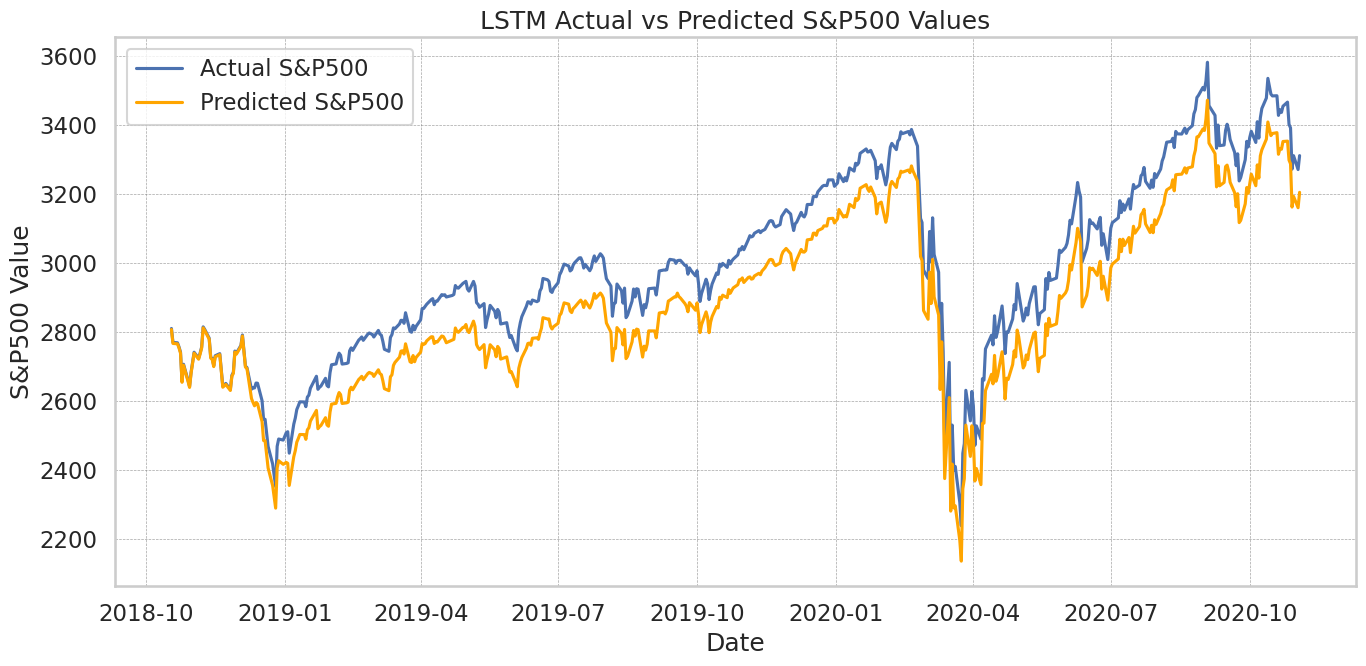

In [11]:
plot_actuals_predicted(lstm_results_df)

### Trading Strategy Simulation Function

In [9]:
spy = pd.read_csv(base_path +'data/SPY.csv')
spy['Date'] = pd.to_datetime(spy['Date'])

In [ ]:
#older
'''def simulate_trading_strategy(results_df, initial_cash=1000):
    # Initialize columns
    results_df['Signal'] = 0  # 1 for Buy, -1 for Sell, 0 for Hold
    results_df['Current'] = initial_cash
    cash = initial_cash
    holding = False
    buy_price = 0

    for i in range(1, len(results_df)):
        # Generate trading signal
        if results_df['Prediction'].iloc[i] > results_df['Prediction'].iloc[i - 1]:
            signal = 1  # Buy
        elif results_df['Prediction'].iloc[i] < results_df['Prediction'].iloc[i - 1]:
            signal = -1  # Sell
        else:
            signal = 0  # Hold

        results_df.at[i, 'Signal'] = signal

        # Execute trade
        if signal == 1 and not holding:  # Buy
            buy_price = spy.loc[spy['Date'] == results_df['Date'].iloc[i], 'Open'].values[0]
            holding = True
        elif signal == -1 and holding:  # Sell
              sell_price = spy.loc[spy['Date'] == results_df['Date'].iloc[i], 'Open'].values[0]
              if sell_price > buy_price:
                cash += cash * (sell_price - buy_price) / buy_price
                holding = False
        results_df.at[i, "Current"] = cash
    # Final cash value includes cash + value of held shares
    final_cash = cash

    # Plot cumulative PnL
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Date'], results_df['Current'], label='Balance', color='blue')
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.title('Simulated Trading Strategy')
    plt.legend()
    plt.grid()
    plt.show()

    return results_df, final_cash'''


In [ ]:
!pip install -U kaleido

In [ ]:
%pip install imageio

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def simulate_trading_strategy_seaborn(results_df, model_name, initial_cash=1000):
    # Initialize columns
    results_df['Signal'] = 0  # 1 for Buy, -1 for Sell, 0 for Hold
    results_df['Current'] = initial_cash
    cash = initial_cash
    holding = False
    buy_price = 0
    shares = 0

    # Merge with spy for accurate price referencing
    results_df = results_df.merge(spy[['Date', 'Open']], on='Date', how='left')

    transaction_cost = 0  # Flat fee per trade
    threshold = 30  # Threshold for significant changes in prediction

    for i in range(1, len(results_df)):
        # Generate trading signal
        if results_df['Prediction'].iloc[i] > results_df['Prediction'].iloc[i - 1] + threshold:
            signal = 1  # Buy
        elif results_df['Prediction'].iloc[i] < results_df['Prediction'].iloc[i - 1] - threshold:
            signal = -1  # Sell
        else:
            signal = 0  # Hold

        results_df.at[i, 'Signal'] = signal

        # Execute trade
        if signal == 1 and not holding:  # Buy
            buy_price = results_df['Open'].iloc[i]
            shares += (cash - transaction_cost) // buy_price
            if shares > 0:
                cash -= shares * buy_price + transaction_cost
                holding = True
        elif signal == -1 and holding:  # Sell
            sell_price = results_df['Open'].iloc[i]
            cash += shares * sell_price - transaction_cost
            holding = False
            shares = 0

        # Update portfolio value
        if holding:
            current_value = cash + shares * results_df['Open'].iloc[i]
        else:
            current_value = cash
        results_df.at[i, 'Current'] = current_value

    # Add value of held shares if any
    final_cash = cash
    if holding:
        final_share_price = results_df['Open'].iloc[-1]
        final_cash += shares * final_share_price

    # Set up Seaborn plot
    sns.set(style="whitegrid")
    sns.set_context("talk")
    plt.figure(figsize=(16, 8))
    sns.lineplot(data=results_df, x='Date', y='Current', color='darkorange', linewidth=2, label='Portfolio')


    # Add titles and labels
    plt.title(f'{model_name} Simulated Trading Strategy')
    plt.xlabel('Date')
    plt.ylabel('Portfolio')
    plt.legend(fontsize=12)
    plt.tight_layout()

    # Show plot
    plt.show()

    return results_df, final_cash


In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def simulate_trading_strategy_smoothed(results_df, model_name, initial_cash=1000):
    # Initialize columns
    results_df['Signal'] = 0  # 1 for Buy, -1 for Sell, 0 for Hold
    results_df['Current'] = initial_cash
    cash = initial_cash
    holding = False
    buy_price = 0
    shares = 0

    # Merge with spy for accurate price referencing
    results_df = results_df.merge(spy[['Date', 'Open']], on='Date', how='left')

    transaction_cost = 0  # Flat fee per trade
    threshold = 30  # Threshold for significant changes in prediction

    for i in range(1, len(results_df)):
        # Generate trading signal
        if results_df['Prediction'].iloc[i] > results_df['Prediction'].iloc[i - 1] + threshold:
            signal = 1  # Buy
        elif results_df['Prediction'].iloc[i] < results_df['Prediction'].iloc[i - 1] - threshold:
            signal = -1  # Sell
        else:
            signal = 0  # Hold

        results_df.at[i, 'Signal'] = signal

        # Execute trade
        if signal == 1 and not holding:  # Buy
            buy_price = results_df['Open'].iloc[i]
            shares += (cash - transaction_cost) // buy_price
            if shares > 0:
                cash -= shares * buy_price + transaction_cost
                holding = True
        elif signal == -1 and holding:  # Sell
            sell_price = results_df['Open'].iloc[i]
            cash += shares * sell_price - transaction_cost
            holding = False
            shares = 0

        # Update portfolio value
        if holding:
            current_value = cash + shares * results_df['Open'].iloc[i]
        else:
            current_value = cash
        results_df.at[i, 'Current'] = current_value

    # Add value of held shares if any
    final_cash = cash
    if holding:
        final_share_price = results_df['Open'].iloc[-1]
        final_cash += shares * final_share_price

    # Resample data to reduce x-axis density (e.g., weekly data)
    results_df['Date'] = pd.to_datetime(results_df['Date'])
    results_df.set_index('Date', inplace=True)
    resampled_df = results_df.resample('W').mean().reset_index()

    # Set up Seaborn plot
    sns.set(style="whitegrid")
    sns.set_context("talk", font_scale=1.2)

    # Set up plot
    plt.figure(figsize=(20, 8))
    sns.lineplot(data=resampled_df, x='Date', y='Current', color='coral', linewidth=2.5, label='Portfolio')

    # Customizing axes and layout
    plt.title(f'{model_name} Simulated Trading Strategy', pad=20)
    plt.xlabel('Date', labelpad=10)
    plt.ylabel('Portfolio', labelpad=10)

    # Format x-axis for smooth, compressed date ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))  # Show ticks every 3 months
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format ticks as "Month Year"
    plt.xticks()


    # Custom gridlines and border
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()

    # Show plot
    plt.legend(loc='upper left', frameon=False)
    plt.show()

    return results_df, final_cash


<ipython-input-124-18b2181b584a>:50: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1008.6400000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



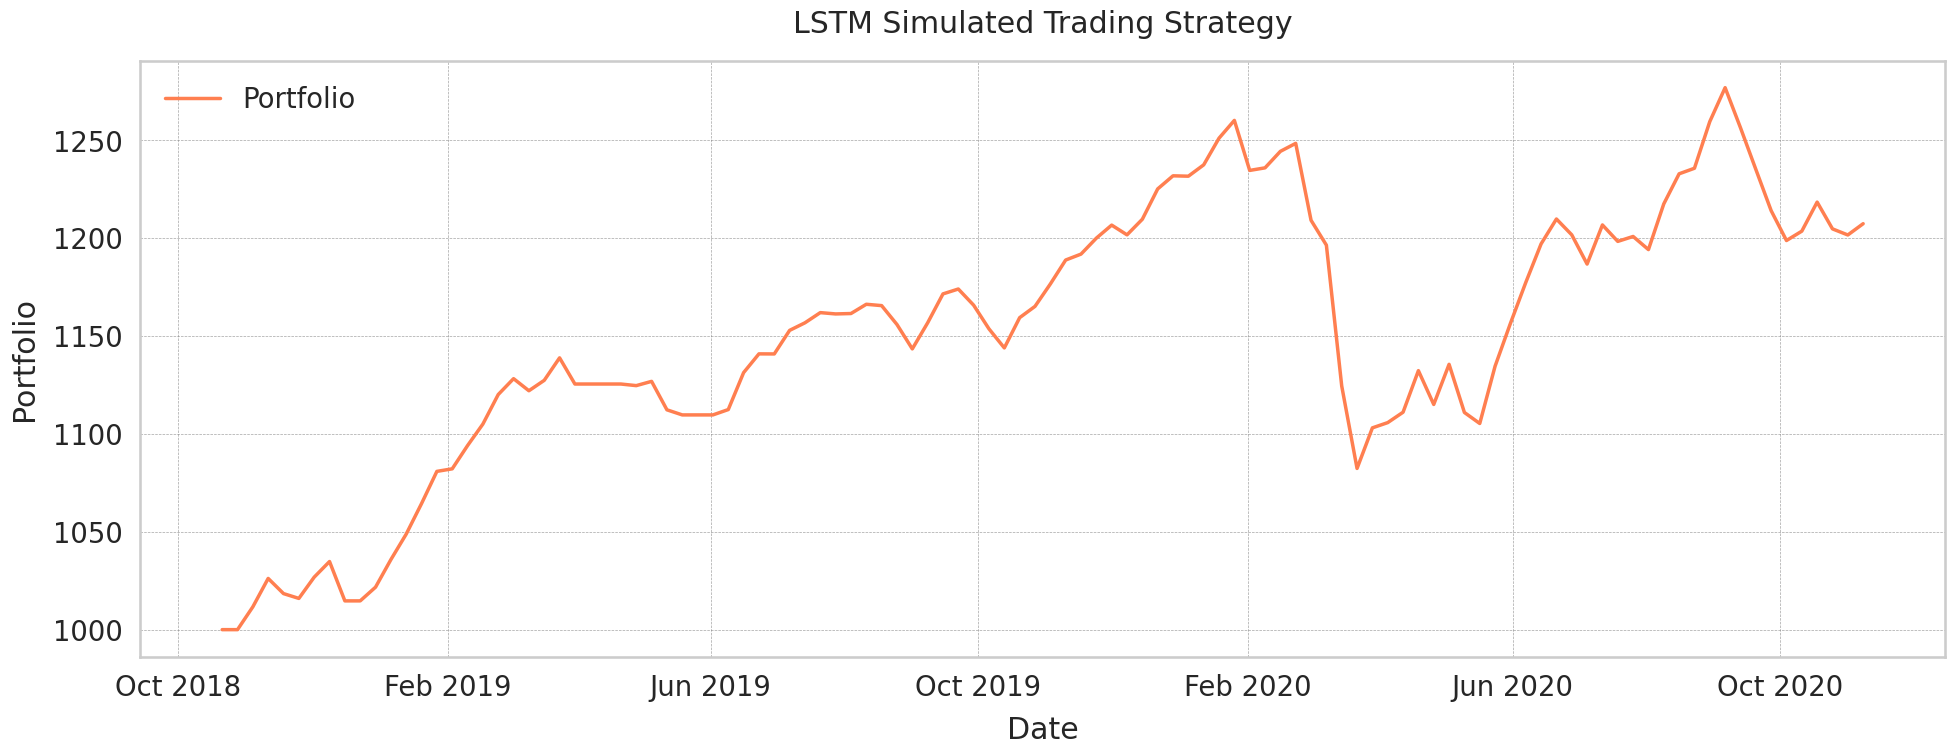

Final Cash: $1207.42
             Prediction       Actual  Signal  Current    Open
Date                                                         
2018-10-18  2806.242725  2809.209961       0   1000.0  279.40
2018-10-19  2765.826658  2768.780029      -1   1000.0  277.13
2018-10-22  2764.823375  2767.780029       0   1000.0  277.00
2018-10-23  2752.948896  2755.879883       0   1000.0  270.95
2018-10-24  2737.757545  2740.689941       0   1000.0  273.33


In [125]:
lstm_results_df.to_csv(base_path + 'lstm_results.csv')

lstm_sim, final_cash = simulate_trading_strategy_smoothed(lstm_results_df, model_name = "LSTM")
print(f"Final Cash: ${final_cash:.2f}")
print(lstm_sim.head())

In [49]:

ini = spy.loc[spy['Date'] == lstm_results_df['Date'].iloc[0], 'Open'].values[0]
fin = spy.loc[spy['Date'] == lstm_results_df['Date'].iloc[-1], 'Open'].values[0]
1000 * (fin - ini) / ini

194.3092340730137

## SARIMAX

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# Load data
data = pd.read_csv(base_path + 'data/processed.csv')
data['Date'] = pd.to_datetime(data['Date'])  # Ensure Date column is datetime

# Sort by date
data = data.sort_values('Date').reset_index(drop=True)

# Select top 50 companies by Marketcap
top_50 = sp_comp.sort_values('Marketcap', ascending=False).head(50)
top_50_symbols = top_50['Symbol'].tolist()

# Filter data to include only the selected companies
features = [
    col for col in data.columns
    if any(col.startswith(prefix) and col[len(prefix):] in top_50_symbols for prefix in ['Open_', 'Close_', 'High_', 'Low_', 'Volume_'])
]

target = 'SP500'

# Handle missing values
data = data.fillna(method='ffill').fillna(method='bfill')

#differentiating for stationarity
data[target + '_diff'] = data[target].diff().fillna(0)

# Train-test split
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Shift the target variable AFTER splitting
train_data[target + '_diff'] = train_data[target + '_diff'].shift(-1)
test_data[target + '_diff'] = test_data[target + '_diff'].shift(-1)

# Drop rows with NaN due to shifting
train_data = train_data.dropna().reset_index(drop=True)
test_data = test_data.dropna().reset_index(drop=True)

train_target = train_data[target + '_diff']
test_target = test_data[target + '_diff']

train_exog = train_data[features]
test_exog = test_data[features]


<ipython-input-117-e98447a8b84b>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


In [ ]:
# Fit SARIMAX with simplified parameters and limited iterations
sarimax_model = SARIMAX(train_target, exog=train_exog, order=(1, 1, 0), seasonal_order=(0, 0, 0, 0))
sarimax_results = sarimax_model.fit(disp=False, maxiter=50, tol=1e-4)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Sample Predictions vs Actuals with Dates:
        Date   Prediction       Actual
0 2018-09-06  2895.419384  2878.050049
1 2018-09-07  2902.250865  2871.679932
2 2018-09-10  2896.291345  2877.129883
3 2018-09-11  2905.773608  2887.889893
4 2018-09-12  2886.558354  2888.919922
5 2018-09-13  2918.099901  2904.179932
6 2018-09-14  2900.937539  2904.979980
7 2018-09-17  2910.114304  2888.800049
8 2018-09-18  2930.541031  2904.310059
9 2018-09-19  2904.550477  2907.949951
Mean Absolute Error on original scale: 388.50056500486386


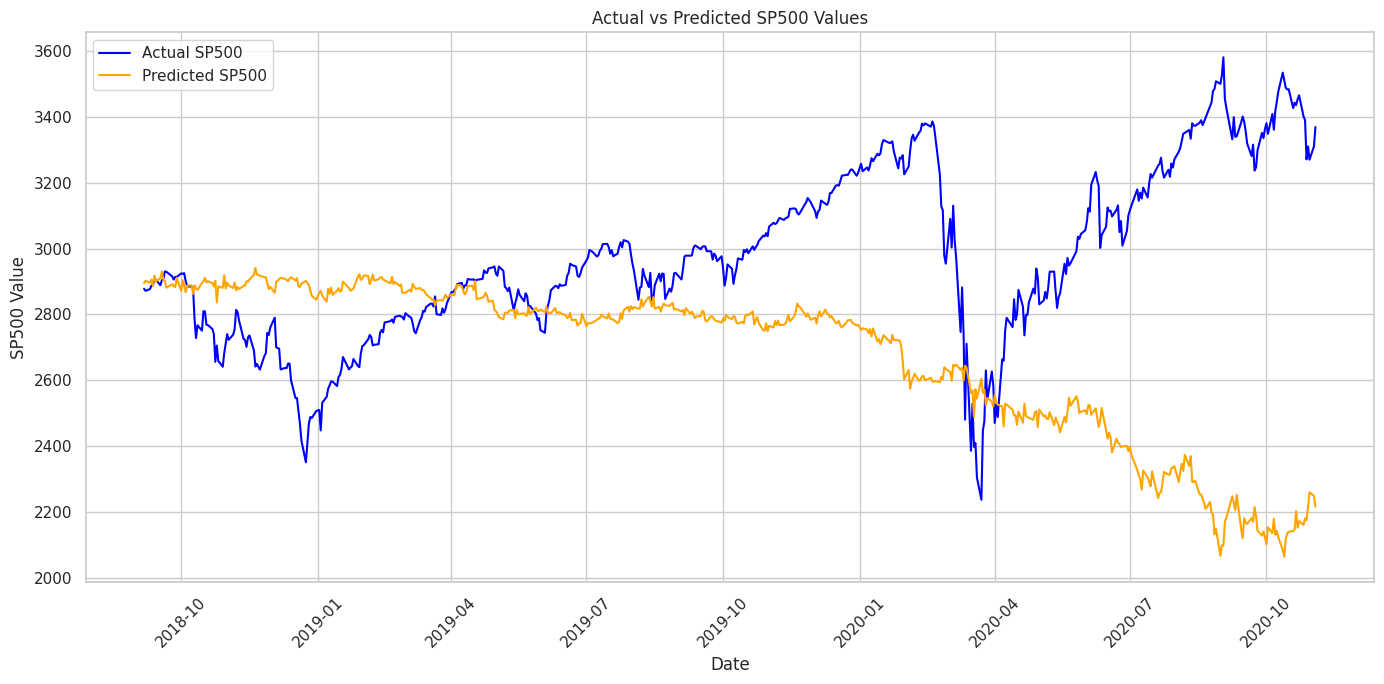

In [ ]:
# Evaluate the SARIMAX model
predicted = sarimax_results.predict(
    start=len(train_target),
    end=len(train_target) + len(test_target) - 1,
    exog=test_exog
)

# Inverse transform predictions and actuals to the original scale
predictions = predicted.values

# Extract dates corresponding to the predictions
prediction_dates = test_data['Date'].reset_index(drop=True)

# Reverse differencing
original_sp500 = test_data[target].iloc[:len(predictions)].values
predictions_original = predictions.flatten() + original_sp500
actuals_original = test_data[target]

# Combine results with dates for better clarity
sarimax_results_df = pd.DataFrame({
    'Date': prediction_dates,
    'Prediction': predictions_original,
    'Actual': actuals_original
})

# Display a sample of the results
print("Sample Predictions vs Actuals with Dates:")
print(sarimax_results_df.head(10))

# Calculate and display metrics
mse = mean_absolute_error(actuals_original, predictions_original)
print(f"Mean Absolute Error on original scale: {mse}")

plot_actuals_predicted(sarimax_results_df)

<ipython-input-214-2fc00444f118>:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1002.22' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results_df.at[i, 'Current'] = current_value


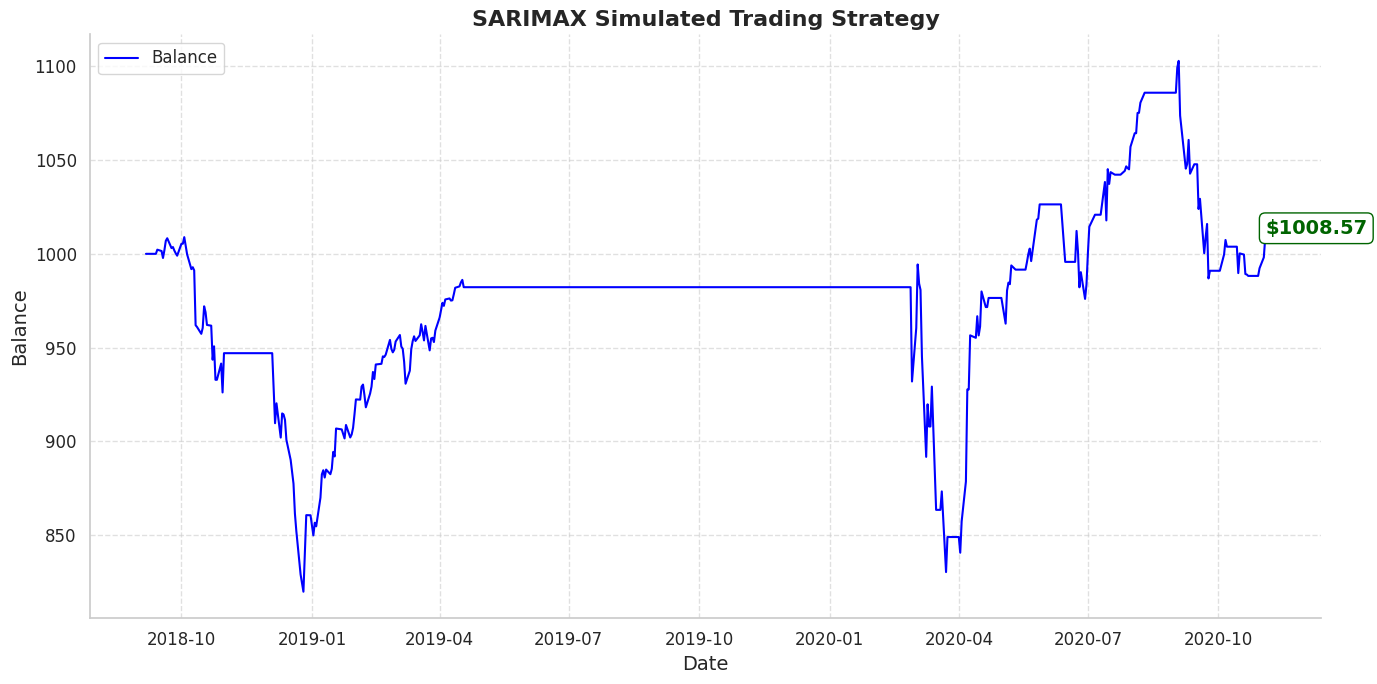

Final Cash: $1008.57
        Date   Prediction       Actual  Signal  Current    Open
0 2018-09-06  2895.419384  2878.050049       0   1000.0  289.15
1 2018-09-07  2902.250865  2871.679932       0   1000.0  286.98
2 2018-09-10  2896.291345  2877.129883       0   1000.0  288.74
3 2018-09-11  2905.773608  2887.889893       0   1000.0  287.37
4 2018-09-12  2886.558354  2888.919922       0   1000.0  289.06


In [ ]:
sarimax_sim, final_cash = simulate_trading_strategy(sarimax_results_df, "SARIMAX")
print(f"Final Cash: ${final_cash:.2f}")
print(sarimax_sim.head())

In [ ]:
sarimax_sim

,Date,Prediction,Actual,Signal,Current
0,2018-09-06,2895.419384,2878.050049,0,1000.000000
1,2018-09-07,2902.250865,2871.679932,1,1000.000000
2,2018-09-10,2896.291345,2877.129883,-1,1006.132832
3,2018-09-11,2905.773608,2887.889893,1,1006.132832
4,2018-09-12,2886.558354,2888.919922,-1,1012.049818
...,...,...,...,...,...
540,2020-10-28,2175.087485,3271.030029,-1,1243.822822
541,2020-10-29,2213.874263,3310.110107,1,1243.822822
542,2020-10-30,2260.351134,3269.959961,1,1243.822822
543,2020-11-02,2248.890430,3310.239990,-1,1243.822822
